In [4]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import resample_img
import os

In [6]:
data_path = 'C:\\Users\\homol\\Documents\\DL\\DL_BHW\\data\\'
#data_path = 'C:/Users/Zsófi/Documents/Deep_Learning_project/'

useful URL's: 
1. https://carpentries-incubator.github.io/SDC-BIDS-IntroMRI/aio/index.html
2. https://neuraldatascience.io/8-mri/read_viz.html
3. https://acdc.creatis.insa-lyon.fr/description/files/tmi_2018_bernard.pdf

patient_4d -> 4d images

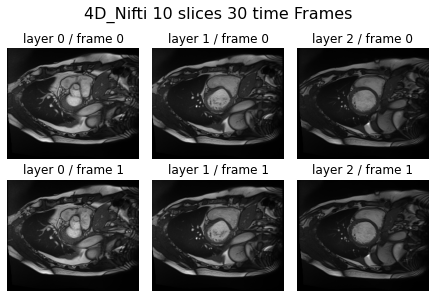

In [8]:
# URL: https://stackoverflow.com/questions/62217462/decompress-nifti-medical-image-in-gz-format-using-python
#==================================
# load image (4D) [X,Y,Z_slice,time]
nii_img  = nib.load(os.path.join(data_path,'training','patient001','patient001_4d.nii.gz'))
nii_data = nii_img.get_fdata()

number_of_frames = 2
number_of_slices = 3

fig, ax = plt.subplots(number_of_frames, number_of_slices,constrained_layout=True)
fig.canvas.set_window_title('4D Nifti Image')
fig.suptitle('4D_Nifti 10 slices 30 time Frames', fontsize=16)
#-------------------------------------------------------------------------------
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()

for slice in range(number_of_slices):
    # if your data in 4D, otherwise remove this loop
    for frame in range(number_of_frames):
        ax[frame, slice].imshow(nii_data[:,:,slice,frame],cmap='gray', interpolation=None)
        ax[frame, slice].set_title("layer {} / frame {}".format(slice, frame))
        ax[frame, slice].axis('off')

plt.show() 

In [5]:
nii_data.shape
"""
In the nifti format, the first three dimensions are reserved to define the three spatial dimensions — x, y and z —, 
while the fourth dimension is reserved to define the time points — t. 
"""

(216, 256, 10, 30)

In [16]:
p1_hdr= nii_img.header
print(p1_hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 216 256  10  30   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 614.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 1071
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x 

In [37]:
nii_img_frame  = nib.load(os.path.join(data_path,'training','patient001','patient001_frame01.nii.gz'))
nii_data_frame = nii_img_frame.get_fdata()
nii_data_frame.shape
"""
Frame = 2D slices 
"""

'\nFrame = 2D slices \n'

In [15]:
p2_hdr= nii_img_frame.header
print(p2_hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          :

In [22]:
nii_img_frame_gt  = nib.load(os.path.join(data_path,'training','patient001','patient001_frame01_gt.nii.gz'))
nii_data_frame_gt = nii_img_frame_gt.get_fdata()
nii_data_frame_gt.shape

(216, 256, 10)

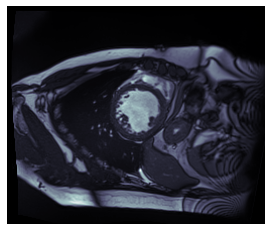

In [37]:
plt.imshow(nii_data_frame[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

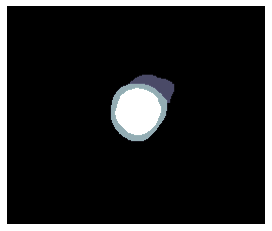

In [46]:
plt.imshow(nii_data_frame_gt[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

In [47]:
img_12 = nib.load(os.path.join(data_path,'training','patient001','patient001_frame12.nii.gz'))
data_12 = img_12.get_fdata()
data_12.shape

(216, 256, 10)

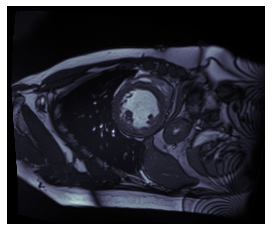

In [48]:
plt.imshow(data_12[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

In [49]:
img_12_gt = nib.load(os.path.join(data_path,'training','patient001','patient001_frame12_gt.nii.gz'))
data_12_gt = img_12_gt.get_fdata()
data_12_gt.shape
# gt ?= ground truth

(216, 256, 10)

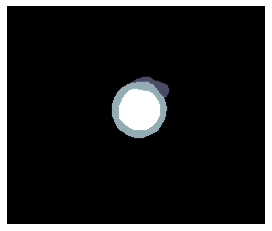

In [50]:
plt.imshow(data_12_gt[:,:,5], cmap='bone')
plt.axis('off')
plt.show()

# Resampling images

In [71]:
downsampled_nii = resample_img(nii_img_frame, target_affine=np.eye(3)*[3,3,1], interpolation='nearest')

In [66]:
print(nii_img_frame.shape)
print(downsampled_nii.shape)

(216, 256, 10)
(109, 129, 10)


(-0.5, 255.5, 215.5, -0.5)

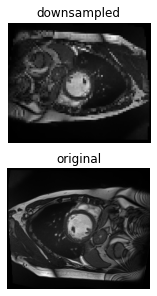

In [72]:
fig, ax = plt.subplots(2,constrained_layout=True)
fig.canvas.set_window_title('Downsampling')

ax[0].imshow(downsampled_nii.dataobj[:,:,4],cmap='gray', interpolation=None)
ax[0].set_title("downsampled")
ax[0].axis('off')

ax[1].imshow(nii_img_frame.dataobj[:,:,4],cmap='gray', interpolation=None)
ax[1].set_title("original")
ax[1].axis('off')

